## 1. Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 2. Load Model & Scaler

In [2]:
# Load trained model and scaler from current directory
try:
    model = joblib.load('flood_model.pkl')
    scaler = joblib.load('flood_scaler.pkl')
    print("✅ Model & scaler loaded successfully!")
except FileNotFoundError:
    print("❌ Error: Run Train.py first to generate model files!")
    exit()

✅ Model & scaler loaded successfully!


## 3. Load and Preprocess FRESH Test Data 

In [3]:
def load_and_preprocess_data(filepath):
    """Load and preprocess data identically to Train.py"""
    df = pd.read_csv(filepath)
    
    # Clip outliers (same thresholds as training)
    df['precip'] = df['precip'].clip(upper=500)
    df['humidity'] = df['humidity'].clip(upper=100)
    
    # Handle missing values (if any)
    if df.isnull().sum().any():
        df.fillna(df.median(), inplace=True)
    
    return df

# Load full dataset
full_df = load_and_preprocess_data("data.csv")  # original file

# Split into features/target (same as Train.py)
X = full_df.drop('class', axis=1)
y = full_df['class']

# --------------------------
# 4. Recreate Test Set 
# (Must match Train.py's random_state=42 and test_size=0.2)
# --------------------------
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,  
    stratify=y
)

# Scale test data (using the SAME scaler)
X_test_scaled = scaler.transform(X_test)

print("✅ Test data recreated and scaled successfully!")


✅ Test data recreated and scaled successfully!


## 4. Normal Ranges

## 5. Predefined FLOOD Case Test

In [4]:
flood_case = {
    'temp': 28.5,       # High temp + humidity
    'max_temp': 32.0,
    'wind_speed': 45.0,  # Storm conditions
    'cloudcover': 95.0,  # Full overcast
    'precip': 350.0,     # Heavy rainfall
    'humidity': 98.0     # Saturated air
}

def predict_flood_risk(data):
    """Predict and print flood risk for given data."""
    df = pd.DataFrame([data])
    scaled_data = scaler.transform(df)
    proba = model.predict_proba(scaled_data)[0][1]
    prediction = "🛑 FLOOD" if proba >= 0.5 else "✅ SAFE"
    
    print("\n=== Flood Risk Prediction ===")
    print(f"Weather Conditions: {data}")
    print(f"Prediction: {prediction}")
    print(f"Probability: {proba:.1%}")
    return proba

# Test the flood case
print("\nTesting HIGH-RISK FLOOD SCENARIO:")
flood_prob = predict_flood_risk(flood_case)




Testing HIGH-RISK FLOOD SCENARIO:

=== Flood Risk Prediction ===
Weather Conditions: {'temp': 28.5, 'max_temp': 32.0, 'wind_speed': 45.0, 'cloudcover': 95.0, 'precip': 350.0, 'humidity': 98.0}
Prediction: 🛑 FLOOD
Probability: 91.6%


## 5. Predefined SAFE Case Test

In [5]:
safe_case = {
    'temp': 22.0,       # Mild weather
    'max_temp': 26.0,
    'wind_speed': 12.0, # Calm winds
    'cloudcover': 30.0, # Partly cloudy
    'precip': 5.0,      # Light rain
    'humidity': 60.0    # Comfortable
}

# Test the safe case
print("\nTesting SAFE WEATHER SCENARIO:")
safe_prob = predict_flood_risk(safe_case)




Testing SAFE WEATHER SCENARIO:

=== Flood Risk Prediction ===
Weather Conditions: {'temp': 22.0, 'max_temp': 26.0, 'wind_speed': 12.0, 'cloudcover': 30.0, 'precip': 5.0, 'humidity': 60.0}
Prediction: ✅ SAFE
Probability: 0.0%


## 6. Model Evaluation on Test Data


=== Test Set Performance ===
Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       408
           1       1.00      0.98      0.99       600

    accuracy                           0.99      1008
   macro avg       0.98      0.99      0.99      1008
weighted avg       0.99      0.99      0.99      1008



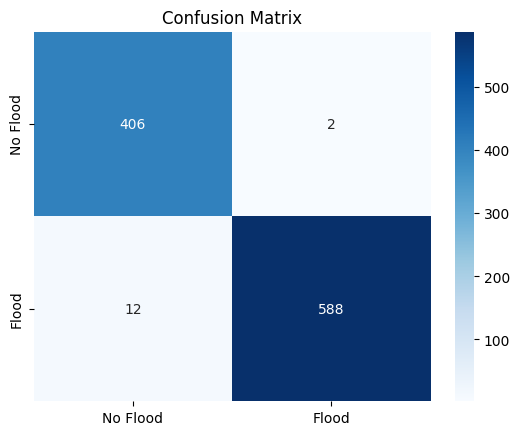

In [6]:
y_pred = model.predict(X_test_scaled)

print("\n=== Test Set Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'])
plt.title("Confusion Matrix")
plt.show()

## 7. Custom Input Prediction


FLOOD RISK PREDICTION TOOL

Enter Weather Parameters (Safe vs Flood Ranges):

🌡️ [T] Temperature (°C)
  Safe: 15-35°C
  Flood Risk: ≥35°C


  Enter value:  38



↑ [M] Max Temperature (°C)
  Safe: 20-40°C
  Flood Risk: ≥40°C


  Enter value:  40



💨 [W] Wind Speed (km/h)
  Safe: 0-30km/h
  Flood Risk: ≥40km/h


  Enter value:  8



☁️ [C] Cloud Cover (%)
  Safe: 0-70%
  Flood Risk: ≥80%


  Enter value:  50



⛈️ [P] Precipitation (mm/day)
  Safe: 0-50mm/day
  Flood Risk: ≥100mm/day


  Enter value:  0



💧 [H] Humidity (%)
  Safe: 30-80%
  Flood Risk: ≥85%


  Enter value:  15



Decision threshold (0-1, default=0.5):  


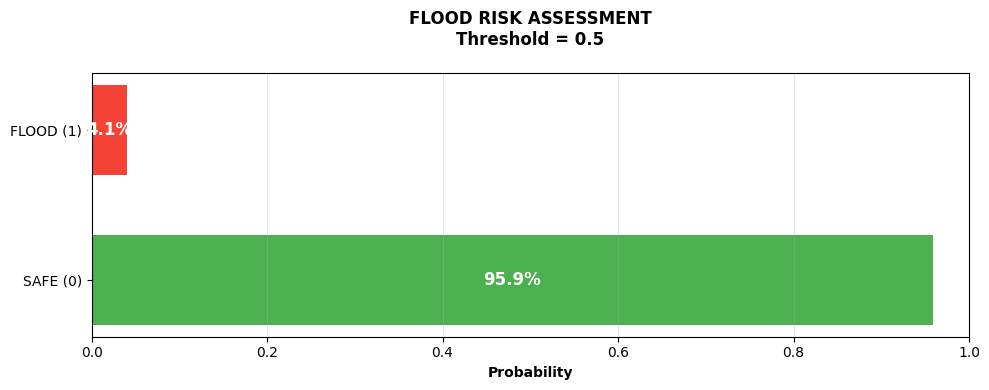

In [7]:
def predict_case(params, model, scaler):
    """Predict flood risk for a single case"""
    df = pd.DataFrame([params])
    scaled_data = scaler.transform(df)
    proba = model.predict_proba(scaled_data)[0][1]
    return proba

def custom_prediction():
    print("\n" + "="*50)
    print("FLOOD RISK PREDICTION TOOL")
    print("="*50)
    
    # Parameter guide with symbols 
    params_guide = {
        'temp': {
            'name': '[T] Temperature',
            'unit': '°C',
            'safe': (15, 35),
            'flood': (35, 50),
            'symbol': '🌡️'  
        },
        'max_temp': {
            'name': '[M] Max Temperature',
            'unit': '°C',
            'safe': (20, 40),
            'flood': (40, 60),
            'symbol': '↑'
        },
        'wind_speed': {
            'name': '[W] Wind Speed',
            'unit': 'km/h',
            'safe': (0, 30),
            'flood': (40, 120),
            'symbol': '💨'
        },
        'cloudcover': {
            'name': '[C] Cloud Cover',
            'unit': '%',
            'safe': (0, 70),
            'flood': (80, 100),
            'symbol': '☁️'
        },
        'precip': {
            'name': '[P] Precipitation',
            'unit': 'mm/day',
            'safe': (0, 50),
            'flood': (100, 500),
            'symbol': '⛈️'
        },
        'humidity': {
            'name': '[H] Humidity',
            'unit': '%',
            'safe': (30, 80),
            'flood': (85, 100),
            'symbol': '💧'
        }
    }
    
    params = {}
    print("\n" + "Enter Weather Parameters (Safe vs Flood Ranges):\n")
    
    for feature, guide in params_guide.items():
        while True:
            try:
                # Display prompt with symbol (console only)
                print(f"{guide['symbol']} {guide['name']} ({guide['unit']})")
                print(f"  Safe: {guide['safe'][0]}-{guide['safe'][1]}{guide['unit']}")
                print(f"  Flood Risk: ≥{guide['flood'][0]}{guide['unit']}")
                
                val = float(input(f"  Enter value: "))
                
                # Validate input
                if guide['unit'] == '%' and not (0 <= val <= 100):
                    print("  Error: Must be 0-100%")
                    continue
                if feature == 'precip' and val < 0:
                    print("  Error: Precipitation can't be negative")
                    continue
                    
                params[feature] = val
                break
                
            except ValueError:
                print("  Invalid input! Please enter a number.")
        print()  # Spacer

    # Prediction
    threshold = float(input("\nDecision threshold (0-1, default=0.5): ") or 0.5)
    proba = predict_case(params, model, scaler)
    
    # Visualization 
    plt.figure(figsize=(10, 4))
    categories = ['SAFE (0)', 'FLOOD (1)']  # Text labels
    bars = plt.barh(
        categories,
        [1-proba, proba], 
        color=['#4CAF50', '#F44336'],  # Green/Red
        height=0.6
    )
    
    # Add probability labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width/2, bar.get_y() + bar.get_height()/2,
                f'{width:.1%}',
                ha='center', va='center',
                color='white', fontweight='bold',
                fontsize=12)
    
    plt.xlim(0, 1)
    plt.title(
        "FLOOD RISK ASSESSMENT\n" +
        f"Threshold = {threshold}",
        fontweight='bold',
        pad=20
    )
    plt.xlabel("Probability", fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Threshold line
    if threshold != 0.5:
        plt.axvline(threshold, color='black', 
                   linestyle=':', linewidth=2,
                   label=f'Threshold ({threshold})')
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

custom_prediction()